# Task 2: Noise, Noise and More Noise

One of the main challenges in quantum computing is the noise in current devices. In this task, you will create a simple noise generator and assess its effect. You can use any framework you like (Qiskit, Cirq, etc.).

# 1. Noise Model

A standard way to represent the noise in a quantum circuit is through Pauli operators ($\sigma_x$, $\sigma_y$, $\sigma_z$). Build a function with input $\alpha$, $\beta$, and `QuantumCircuit` where:

- $\alpha$: Probability of having a random Pauli operator acting on the qubit after a one-qubit gate.
- $\beta$: Probability of having a random Pauli operator acting on the qubit after a two-qubit gate.
- `QuantumCircuit`: Quantum circuit where the noise will be added.

The output should be the `QuantumCircuit` wit noise.


# 2. Gate Basis

Quantum computers can implement only a set of gates that, with transformations, can represent any other possible gate. This set of gates is called the Gate Basis of the QPU. Build a function that transforms a general `QuantumCircuit` to the following gate basis: \{CX, ID, RZ, SX, X\}.

# 3. Adding Two Numbers with a Quantum Computer

Build a function (`quantum_sum`) to add two numbers using the Draper adder algorithm. You will need the Quantum Fourier Transform (QFT). Many libraries offer a function to use it. For this task, you will need to build QFT from scratch.

# 4. Effects of Noise on Quantum Addition

Now, we can combine all the functions. Transform the circuit used in the `quantum_sum` to the gate basis and add noise. Use different levels of noise and analyze the results.

- How does the noise affect the results?
- Is there a way to decrease the effect of noise?
- How does the number of gates used affect the results?

# References

[3] Quantum arithmetic with the Quantum Fourier Transform: [https://arxiv.org/pdf/1411.5949.pdf](https://arxiv.org/pdf/1411.5949.pdf)


In [7]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel, pauli_error, depolarizing_error, thermal_relaxation_error
)
from qiskit.quantum_info import state_fidelity

import os
import numpy as np
import matplotlib.pyplot as plt

# 1. Noise Model

Define a function to add noise to a quantum circuit:

In [9]:
def add_noise(alpha, beta):
    noise_model = NoiseModel()

    # Define single-qubit Pauli noise
    single_qubit_pauli = pauli_error([('X', alpha/3), ('Y', alpha/3), ('Z', alpha/3), ('I', 1 - alpha)])
    two_qubit_pauli = pauli_error([('IX', beta/3), ('IY', beta/3), ('IZ', beta/3), ('II', 1 - beta)])

    # Add noise for single-qubit and two-qubit gates
    noise_model.add_all_qubit_quantum_error(single_qubit_pauli, ['u1', 'u2', 'u3', 'rx', 'ry', 'rz'])
    noise_model.add_all_qubit_quantum_error(two_qubit_pauli, ['cx'])

    return noise_model

# 2) Gate Basis Transformation
Transform the circuit to use a specific gate set:

In [11]:
def transform_to_basis(circuit, optimization_level=0):
    basis_gates = ['cx', 'id', 'rz', 'sx', 'x']
    transformed_circuit = transpile(circuit, basis_gates=basis_gates, optimization_level=optimization_level)
    return transformed_circuit

# 3) Adding two numbers with a quantum computer
Build a QFT adder for adding two numbers:

In [13]:
def qft(num_qubits, inverse=False, do_swaps=True):
    # Initialize a quantum circuit with the specified number of qubits
    qc = QuantumCircuit(num_qubits)

    # Apply swaps at the beginning if performing inverse QFT
    if do_swaps and inverse:
        for i in range(num_qubits // 2):
            qc.swap(num_qubits // 2 - 1 - i, num_qubits + i - 2)

    # Apply the QFT or inverse QFT rotations
    for j in reversed(range(num_qubits)):
        if not inverse:
            # Apply controlled phase gates from j to all qubits with a higher index
            for k in reversed(range(j + 1, num_qubits)):
                lam = np.pi / 2 ** (k - j)
                qc.cp(lam, j, k)

            # Apply the Hadamard gate to the j-th qubit
            qc.h(j)
        else:

            j = num_qubits - j - 1

            # Apply controlled phase gates for the inverse QFT
            for k in range(j):
                lam = -np.pi / 2 ** (j - k)
                qc.cp(lam, k, j)

            # Apply the Hadamard gate to the j-th qubit
            qc.h(j)


    # Apply swaps at the end if performing the regular QFT
    if do_swaps and not inverse:
        for i in range(num_qubits // 2):
            qc.swap(i, num_qubits - i - 1)

    return qc


def draper_qft_adder(num1, num2):
    # Determine the number of qubits needed based on the bit length of the sum
    max_value = num1 + num2
    num_qubits = max_value.bit_length() + 1  # +1 to account for potential overflow

    # Create a quantum circuit with registers for |a⟩ and |b⟩
    qr_a = QuantumCircuit(num_qubits, name="a")
    qr_b = QuantumCircuit(num_qubits, name="b")

    # Initialize |a⟩ with num1 and |b⟩ with num2 using the binary representation
    for i in range(num_qubits):
        if (num1 >> i) & 1:
            qr_a.x(i)
        if (num2 >> i) & 1:
            qr_b.x(i)

    # Combine both registers into a single circuit
    circuit = QuantumCircuit(num_qubits * 2)
    circuit.compose(qr_a, qubits=range(num_qubits), inplace=True)
    circuit.compose(qr_b, qubits=range(num_qubits, num_qubits * 2), inplace=True)

    # Apply custom QFT to the second register |b⟩
    qft_circuit = qft(num_qubits, do_swaps=False)
    circuit.append(qft_circuit.to_gate(), range(num_qubits, num_qubits * 2))

    # Add controlled phase rotations for the QFT addition
    for j in range(num_qubits):
        for k in range(num_qubits - j):
            lam = np.pi / (2 ** k)
            circuit.cp(lam, j, num_qubits + j + k)

    # Apply inverse custom QFT to the second register |b⟩
    iqft_circuit = qft(num_qubits, do_swaps=False, inverse=True)
    circuit.append(iqft_circuit.to_gate(), range(num_qubits, num_qubits * 2))

    # Measure the result
    circuit.measure_all()

    return circuit

# 4) Effects of noise on quantum addition
Simulate the quantum adder with noise:

In [15]:
def calculate_fidelity(ideal_counts, noisy_counts, num_qubits):
    # Convert counts to probability distributions
    total_ideal = sum(ideal_counts.values())
    total_noisy = sum(noisy_counts.values())

    ideal_prob_dist = {k: v / total_ideal for k, v in ideal_counts.items()}
    noisy_prob_dist = {k: v / total_noisy for k, v in noisy_counts.items()}

    # Calculate the overlap between ideal and noisy distributions (state fidelity)
    overlap = 0
    for state, prob in ideal_prob_dist.items():
        if state in noisy_prob_dist:
            overlap += np.sqrt(prob * noisy_prob_dist[state])

    return overlap**2  # Fidelity is the square of the overlap


def assess_and_verify_qft_adder(num1, num2, alpha, beta, optimization_level):
    # Build the quantum adder circuit
    sum_circuit = draper_qft_adder(num1, num2)
    num_qubits = sum_circuit.num_qubits // 2  # Number of qubits in each input register

    # Ideal simulation (no noise)
    ideal_simulator = AerSimulator()
    transpiled_ideal_qc = transpile(sum_circuit, ideal_simulator)
    ideal_job = ideal_simulator.run(transpiled_ideal_qc, shots=1024)
    ideal_result = ideal_job.result()
    ideal_counts = ideal_result.get_counts()

    # Noisy simulation
    noise_model = add_noise(alpha, beta)
    noisy_simulator = AerSimulator(noise_model=noise_model)
    transpiled_noisy_qc = transpile(sum_circuit, noisy_simulator, optimization_level=optimization_level)
    noisy_job = noisy_simulator.run(transpiled_noisy_qc, shots=1024)
    noisy_result = noisy_job.result()
    noisy_counts = noisy_result.get_counts()

    # Determine the most likely outcome from the measurement counts
    measured_state = max(noisy_counts, key=noisy_counts.get)
    quantum_result = int(measured_state[:num_qubits], 2)

    # Verify the result against the classical sum
    classical_sum = num1 + num2
    is_correct = quantum_result == classical_sum

    # Calculate fidelity between ideal and noisy results
    fidelity = calculate_fidelity(ideal_counts, noisy_counts, num_qubits)

    # Collect the number of single-qubit and two-qubit gates, the depth, and total number of qubits
    num_single_qubit_gates = sum(1 for gate in transpiled_noisy_qc.data if len(gate.qubits) == 1)
    num_two_qubit_gates = sum(1 for gate in transpiled_noisy_qc.data if len(gate.qubits) == 2)
    circuit_depth = transpiled_noisy_qc.depth()
    total_num_qubits = transpiled_noisy_qc.num_qubits  # Total number of qubits in the entire circuit

    # Return results in a dictionary for easier processing
    return {
        'quantum_result': quantum_result,
        'classical_sum': classical_sum,
        'correct': is_correct,
        'fidelity': fidelity,
        'num_single_qubit_gates': num_single_qubit_gates,
        'num_two_qubit_gates': num_two_qubit_gates,
        'circuit_depth': circuit_depth,
        'num_qubits': total_num_qubits,
        'noise_level': (alpha, beta),
        'counts': noisy_counts
    }

def run_qft_adder_tests(test_cases, optimization_level=0, noise_levels=None):
    if noise_levels is None:
        noise_levels = np.linspace(0.0, 0.1, 10)  # Default noise levels from 0 to 0.1

    # Prepare storage for results
    fidelity_results = {f"{num1} + {num2}": [] for num1, num2 in test_cases}
    gate_counts = {
        'num_single_qubit_gates': [],
        'num_two_qubit_gates': [],
        'circuit_depth': [],
        'num_qubits': [],
        'labels': []
    }

    for num1, num2 in test_cases:
        print(f"\nRunning QFT Adder Tests for Adding {num1} + {num2} with Optimization Level {optimization_level}:\n")
        fidelities = []

        # Test for each noise level and gather fidelities
        for noise_level in noise_levels:
            result = assess_and_verify_qft_adder(num1, num2, noise_level, noise_level, optimization_level=optimization_level)
            fidelity = result['fidelity']
            fidelities.append(fidelity)
            print(f"  Noise Level (alpha={noise_level}, beta={noise_level}): Fidelity = {fidelity}, Quantum Result: {result['quantum_result']}, Classical Sum: {result['classical_sum']}, Correct: {result['correct']}")

        # Store the results for plotting
        fidelity_results[f"{num1} + {num2}"] = fidelities

        # Collect gate count data from the last run (for a noise-free scenario)
        gate_counts['num_single_qubit_gates'].append(result['num_single_qubit_gates'])
        gate_counts['num_two_qubit_gates'].append(result['num_two_qubit_gates'])
        gate_counts['circuit_depth'].append(result['circuit_depth'])
        gate_counts['num_qubits'].append(result['num_qubits'])
        gate_counts['labels'].append(f"{num1} + {num2}")

    return fidelity_results, gate_counts, noise_levels


def plot_qft_adder_results(fidelity_results, gate_counts, noise_levels):
    # Plotting the fidelity against noise levels for each test case
    # Create 'plots' directory if it doesn't exist
    os.makedirs('plots', exist_ok=True)
    plt.figure(figsize=(10, 6))
    for label, fidelities in fidelity_results.items():
        plt.plot(noise_levels, fidelities, marker='o', linestyle='-', label=label)
    plt.title("Fidelity of Quantum Addition for Various Inputs")
    plt.xlabel("Noise Level (alpha and beta)")
    plt.ylabel("Fidelity")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(title="Test Cases", loc='best')
    plt.savefig("plots/addition_fidelity_by_noise_level.png")
    plt.show()

    # Plot gate counts using bar plots for comparison
    x = np.arange(len(gate_counts['labels']))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - 1.5 * width, gate_counts['num_single_qubit_gates'], width, label='1-Qubit Gates')
    ax.bar(x - 0.5 * width, gate_counts['num_two_qubit_gates'], width, label='2-Qubit Gates')
    ax.bar(x + 0.5 * width, gate_counts['circuit_depth'], width, label='Circuit Depth')
    ax.bar(x + 1.5 * width, gate_counts['num_qubits'], width, label='Number of Qubits')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Test Case')
    ax.set_ylabel('Count')
    ax.set_title('Gate Counts, Circuit Depth, and Qubits for Different QFT Adder Inputs')
    ax.set_xticks(x)
    ax.set_xticklabels(gate_counts['labels'])
    ax.legend(loc='best')
    plt.grid(True)
    plt.savefig("plots/circuit_statistics.png")
    plt.show()

# How does the noise affect the results?
Noise quickly lowers fidelity, especially for larger sums, as you can see from the plots below. Smaller sums (like 1 + 1) handle noise better, while larger sums (like 10 + 15) drop in accuracy faster due to their increased complexity. More qubits, gates, and circuit depth mean more points where noise can introduce errors, making complex circuits more sensitive to noise.

In [17]:
# Define test cases
test_cases = [
    (1, 1),
    (2, 3),
    (5, 10),
    (7, 6),
    (10, 15)
]

# Run tests for the specified test cases with optimization level 0
fidelity_results, gate_counts, noise_levels = run_qft_adder_tests(test_cases, optimization_level=0)


Running QFT Adder Tests for Adding 1 + 1 with Optimization Level 0:

  Noise Level (alpha=0.0, beta=0.0): Fidelity = 1.0, Quantum Result: 2, Classical Sum: 2, Correct: True
  Noise Level (alpha=0.011111111111111112, beta=0.011111111111111112): Fidelity = 0.61328125, Quantum Result: 2, Classical Sum: 2, Correct: True
  Noise Level (alpha=0.022222222222222223, beta=0.022222222222222223): Fidelity = 0.388671875, Quantum Result: 2, Classical Sum: 2, Correct: True
  Noise Level (alpha=0.03333333333333333, beta=0.03333333333333333): Fidelity = 0.26855468750000006, Quantum Result: 2, Classical Sum: 2, Correct: True
  Noise Level (alpha=0.044444444444444446, beta=0.044444444444444446): Fidelity = 0.1826171875, Quantum Result: 2, Classical Sum: 2, Correct: True
  Noise Level (alpha=0.05555555555555556, beta=0.05555555555555556): Fidelity = 0.12207031250000001, Quantum Result: 2, Classical Sum: 2, Correct: True
  Noise Level (alpha=0.06666666666666667, beta=0.06666666666666667): Fidelity = 0.10

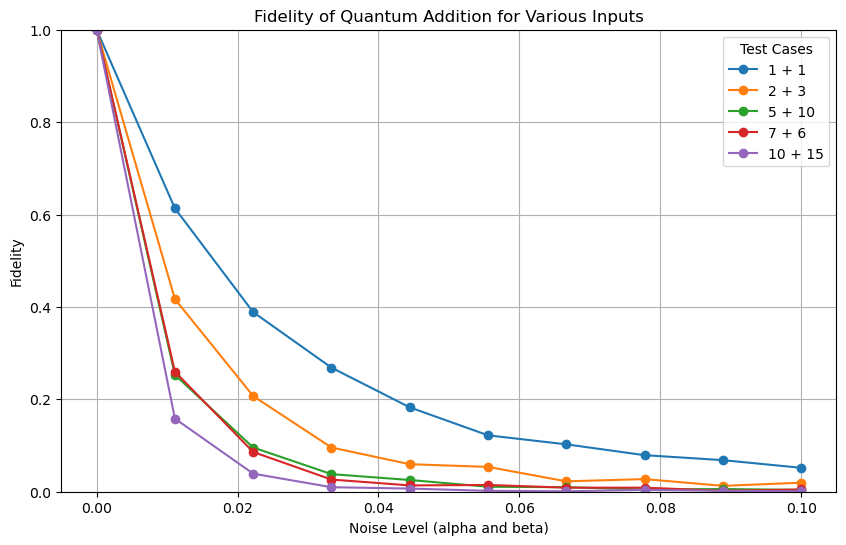

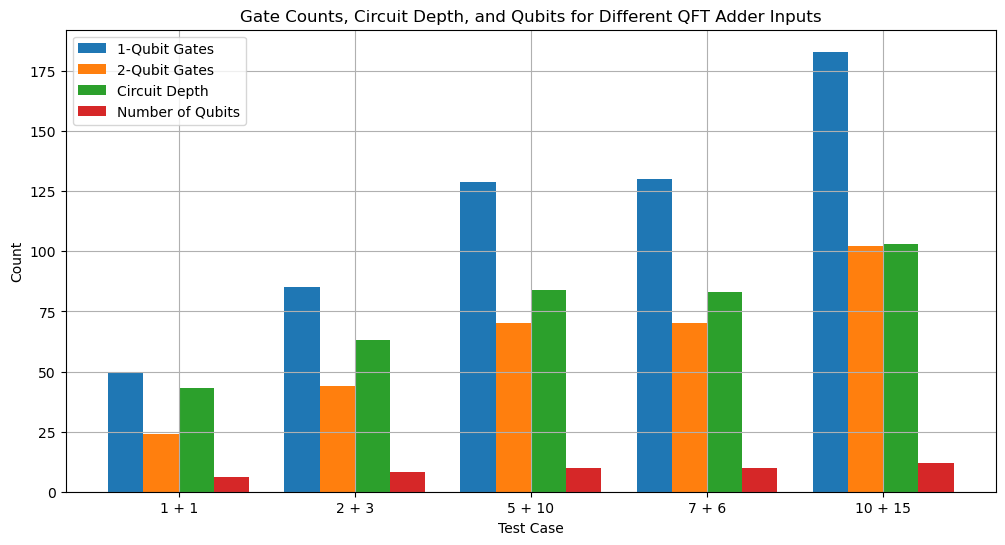

In [19]:
plot_qft_adder_results(fidelity_results, gate_counts, noise_levels)

# Is there a way to decrease the effect of noise?, How does the number of gates used affect the results?
There are several ways to decrease the effect of noise in quantum circuits, such as reducing the number of gates, decreasing the circuit depth, and changing the circuit layout. As shown in the plot below, using a higher optimization level (which reduces the number of gates and depth) results in better fidelity, especially at lower noise levels. This indicates that optimizing the circuit can make it more resilient to noise.

In [21]:
test_cases = [
    (10, 3)
]
# Run tests for the specified test cases with optimization level 0
fidelity_results_0, gate_counts_0, noise_levels_0 = run_qft_adder_tests(test_cases, optimization_level=0)

# Run tests for the specified test cases with optimization level 3
fidelity_results_3, gate_counts_3, noise_levels_3 = run_qft_adder_tests(test_cases, optimization_level=3)


Running QFT Adder Tests for Adding 10 + 3 with Optimization Level 0:

  Noise Level (alpha=0.0, beta=0.0): Fidelity = 1.0, Quantum Result: 13, Classical Sum: 13, Correct: True
  Noise Level (alpha=0.011111111111111112, beta=0.011111111111111112): Fidelity = 0.244140625, Quantum Result: 13, Classical Sum: 13, Correct: True
  Noise Level (alpha=0.022222222222222223, beta=0.022222222222222223): Fidelity = 0.09277343749999999, Quantum Result: 13, Classical Sum: 13, Correct: True
  Noise Level (alpha=0.03333333333333333, beta=0.03333333333333333): Fidelity = 0.03613281249999999, Quantum Result: 13, Classical Sum: 13, Correct: True
  Noise Level (alpha=0.044444444444444446, beta=0.044444444444444446): Fidelity = 0.027343750000000003, Quantum Result: 13, Classical Sum: 13, Correct: True
  Noise Level (alpha=0.05555555555555556, beta=0.05555555555555556): Fidelity = 0.006835937500000001, Quantum Result: 21, Classical Sum: 13, Correct: False
  Noise Level (alpha=0.06666666666666667, beta=0.066

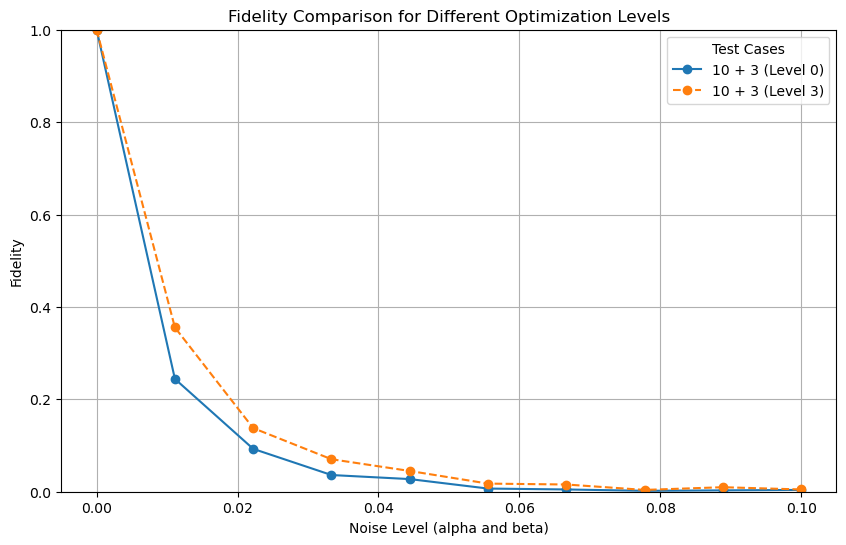


Gate Counts and Circuit Depth Comparison:
Optimization Level 0: {'num_single_qubit_gates': [129], 'num_two_qubit_gates': [70], 'circuit_depth': [83], 'num_qubits': [10], 'labels': ['10 + 3']}
Optimization Level 3: {'num_single_qubit_gates': [97], 'num_two_qubit_gates': [65], 'circuit_depth': [75], 'num_qubits': [10], 'labels': ['10 + 3']}


In [23]:
def plot_optimization_comparison(fidelity_results_0, gate_counts_0, fidelity_results_3, gate_counts_3, noise_levels):
    plt.figure(figsize=(10, 6))

    # Plot fidelity for each test case with optimization level 0 and 3
    for label in fidelity_results_0:
        plt.plot(noise_levels, fidelity_results_0[label], marker='o', linestyle='-', label=f"{label} (Level 0)")
        plt.plot(noise_levels, fidelity_results_3[label], marker='o', linestyle='--', label=f"{label} (Level 3)")

    plt.title("Fidelity Comparison for Different Optimization Levels")
    plt.xlabel("Noise Level (alpha and beta)")
    plt.ylabel("Fidelity")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(title="Test Cases", loc='best')
    plt.savefig("plots/addition_fidelity_level_comparison.png")
    plt.show()

    print("\nGate Counts and Circuit Depth Comparison:")
    print(f"Optimization Level 0: {gate_counts_0}")
    print(f"Optimization Level 3: {gate_counts_3}")

# Plot the comparison between optimization levels 0 and 3 for the specified test cases
plot_optimization_comparison(fidelity_results_0, gate_counts_0, fidelity_results_3, gate_counts_3, noise_levels_0)